In [1]:
import os
os.environ['R_HOME'] = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
from rpy2.rinterface_lib import openrlib
openrlib.R_HOME = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
import scanpy as sc

In [2]:
%load_ext rpy2.ipython

In [3]:
adata_tcr = sc.read_h5ad('./data/mouse_2_4_6wks_scrna.h5ad')

In [6]:
data = adata_tcr.X
obs = adata_tcr.obs
umap = adata_tcr.obsm['X_umap']
gene_names = adata_tcr.var_names

In [16]:
%%R
library(Seurat)
library(dplyr)
library(ggplot2)

In [9]:
colors = ['#DCD300', '#008856', '#E25822', '#882D17', '#F6A600',
           '#654522', '#8DB600', '#604E97', '#F38400', '#875692',
           '#B3446C', '#2B3D26', '#848482', '#BE0032', '#0067A5',
           '#C2B280', 'blueviolet']
names = ['IL10+ Treg', 'IL10- Treg', 
              'CD4 RLE',
             'Tfh', 'PD1+ Th1', 'Th2', 'Th17',
             'Th1', 'Memory CD4', 'Memory CD8',
              'TD CD8', 'Effector CD8', 
              'Cytotoxic gdT', 'CD8aa', 'ILTCK #2',
              'ILTCK #1', 'Rorgt gdT']

celltype_colors = dict(zip(names, colors))

batch_colors = ['#F8766D', '#00BFC4']
names_batch_colors = ['Cecum', 'Tumor']

batch_colors_d = dict(zip(names_batch_colors, batch_colors))


colors += ['#50C878', '#6495ED']
names += ['early PD1+ CD8', 'Proliferating']
celltype_tcr_colors = dict(zip(names, colors))

In [10]:
%%R -i data,obs,umap,gene_names,colors,names
rownames(data) <- rownames(obs)
colnames(data) <- gene_names
data <- as.matrix(t(data), sparse=TRUE)

scrna.tcr.object <- CreateSeuratObject(counts=NULL, data=data)
scrna.tcr.object@meta.data <- obs
celltype_tcr_colors <- colors
names(celltype_tcr_colors) <- names
scrna.tcr.object$celltype_label <- factor(scrna.tcr.object$celltype_label, 
                                      levels = rev(c("Proliferating", "Rorgt gdT", "ILTCK #1", "ILTCK #2", "TD CD8", "early PD1+ CD8", 
                                        "Cytotoxic gdT", "CD8aa", "Effector CD8", "Memory CD8", "Memory CD4", "Th2", "Tfh", "Th1",
                                                 "Th17", "PD1+ Th1", "CD4 RLE", "IL10+ Treg", "IL10- Treg")))

/data1/lesliec/sneha/anaconda/envs/crc-env/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "PhenoGraph_clusters". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.

R[write to console]: Warning:
R[write to console]:  No layers found matching search pattern provided



`summarise()` has grouped output by 'timepoint_label'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'timepoint_label'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'timepoint_label'. You can override using
the `.groups` argument.


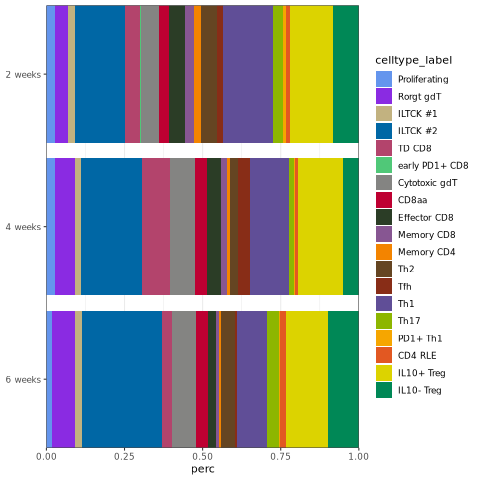

In [17]:
%%R
celltype_order_df <- data.frame(celltype_label=c("Proliferating", "Rorgt gdT", "ILTCK #1", "ILTCK #2", "TD CD8", "early PD1+ CD8", 
                                        "Cytotoxic gdT", "CD8aa", "Effector CD8", "Memory CD8", "Memory CD4", "Th2", "Tfh", "Th1",
                                                 "Th17", "PD1+ Th1", "CD4 RLE", "IL10+ Treg", "IL10- Treg"))
celltype_order_df$order <- 1:dim(celltype_order_df)[1]

d2 <- scrna.tcr.object[, scrna.tcr.object$batch=='Cecum' & scrna.tcr.object$timepoint_label=='2 weeks']@meta.data %>% 
  group_by(timepoint_label, celltype_label) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))
d2 <- merge(celltype_order_df[celltype_order_df$celltype_label %in% d2$celltype_label, ], d2, by='celltype_label')

d4 <- scrna.tcr.object[, scrna.tcr.object$batch=='Cecum' & scrna.tcr.object$timepoint_label=='4 weeks']@meta.data %>% 
  group_by(timepoint_label, celltype_label) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))
d4 <- merge(celltype_order_df, d4, by='celltype_label')

d6 <- scrna.tcr.object[, scrna.tcr.object$batch=='Cecum' & scrna.tcr.object$timepoint_label=='6 weeks']@meta.data %>% 
  group_by(timepoint_label, celltype_label) %>% 
  summarise(count = n()) %>% 
  mutate(perc = count/sum(count))
d6 <- merge(celltype_order_df, d6, by='celltype_label')

d246 <- rbind(rbind(d2, d4), d6)
d246 <- d246[order(d246$order),]
levels(d246$celltype_label) <- celltype_order_df$celltype_label

d246$celltype_label <- factor(d246$celltype_label, levels=c("Proliferating", "Rorgt gdT", "ILTCK #1", "ILTCK #2", "TD CD8", "early PD1+ CD8", 
                                        "Cytotoxic gdT", "CD8aa", "Effector CD8", "Memory CD8", "Memory CD4", "Th2", "Tfh", "Th1",
                                                 "Th17", "PD1+ Th1", "CD4 RLE", "IL10+ Treg", "IL10- Treg"))

p2 <- ggplot(d246, aes(y = factor(timepoint_label), x = perc, fill = factor(celltype_label))) +
  geom_bar(stat="identity", position = position_fill(reverse = TRUE)) + scale_fill_manual("celltype_label", values=celltype_tcr_colors) + 
    theme_bw() + 
    #geom_col(position = position_stack(reverse = TRUE)) + 
    scale_x_continuous(expand = c(0, 0), limits = c(0, 1)) + 
    scale_y_discrete(limits=rev, expand=c(0,0)) +
    #theme(legend.position = "none", axis.text.y=element_blank(), axis.ticks.y=element_blank(), plot.margin=grid::unit(c(0,0,0,0), "mm")) + 
    #theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), plot.margin=grid::unit(c(0,0,0,0), "mm")) + 
              labs(y=NULL)

#ggsave(
#  plot = p2,
#  filename = "outfiles/scrna_tcr_cell_counts_tumor.pdf",
#  bg = "transparent", width = 15, height = 4
#)

p2